# Quadcopter Activity Recognition 

Welcome to this training module that teaches you how to perform activity recognition with the help of a hosted Machine Learning instance. This notebook will guide you through the process of extracting information from your flight record!

## Getting started

So let's start with what group name you are... this will help me pull your raw accelerometer data from the cloud

In [107]:
import json
import boto3
import boto3.session
import string

access_key = ''
secret_key = ''

def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)

GROUP_NAME = input('Group Name: ')
print ('Pulling flight data from S3 for group [', GROUP_NAME ,'] ...')

# Check the group-evaluation object in S3 for existing groups
session = boto3.session.Session(aws_access_key_id=access_key, aws_secret_access_key=secret_key)
s3 = session.resource(service_name='s3', verify=True)
client = s3.meta.client


print('Getting from: /edison-quadcopter/data-flight-recordings/evaluation-data-groups/' + GROUP_NAME + '/rotor-dummy-flight-record.csv')

ensure_dir('./data/evaluation-by-group/' + GROUP_NAME + '/rotor-dummy-flight-record.csv')

group_flight_record = client.download_file(Bucket='mldelarosa-thesis',
                                           Key='edison-quadcopter/data-flight-recordings/evaluation-data-groups/' + GROUP_NAME + '/rotor-dummy-flight-record.csv',
                                           Filename='./data/evaluation-by-group/' + GROUP_NAME + '/rotor-dummy-flight-record.csv')

print('DONE!')
# print('Existing groups:')
# existing_groups = client.list_objects(Bucket='mldelarosa-thesis',
#                                      Prefix='edison-quadcopter/data-flight-recordings/evaluation-data-groups/',
#                                      Delimiter='/')
# if any(GROUP_NAME in prefix for prefix in existing_groups['CommonPrefixes']):
#     print('Found Group!')

# response = client.list_buckets()
# print(response)

Group Name: tesla
Pulling flight data from S3 for group [ tesla ] ...
Getting from: /edison-quadcopter/data-flight-recordings/evaluation-data-groups/tesla/rotor-dummy-flight-record.csv
None


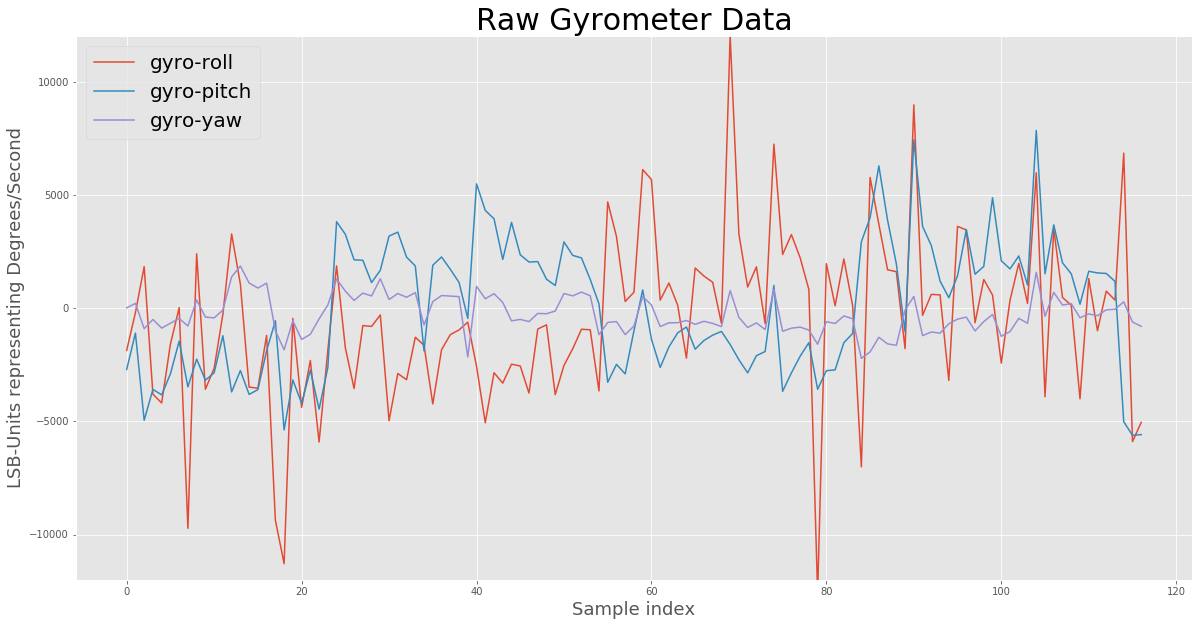

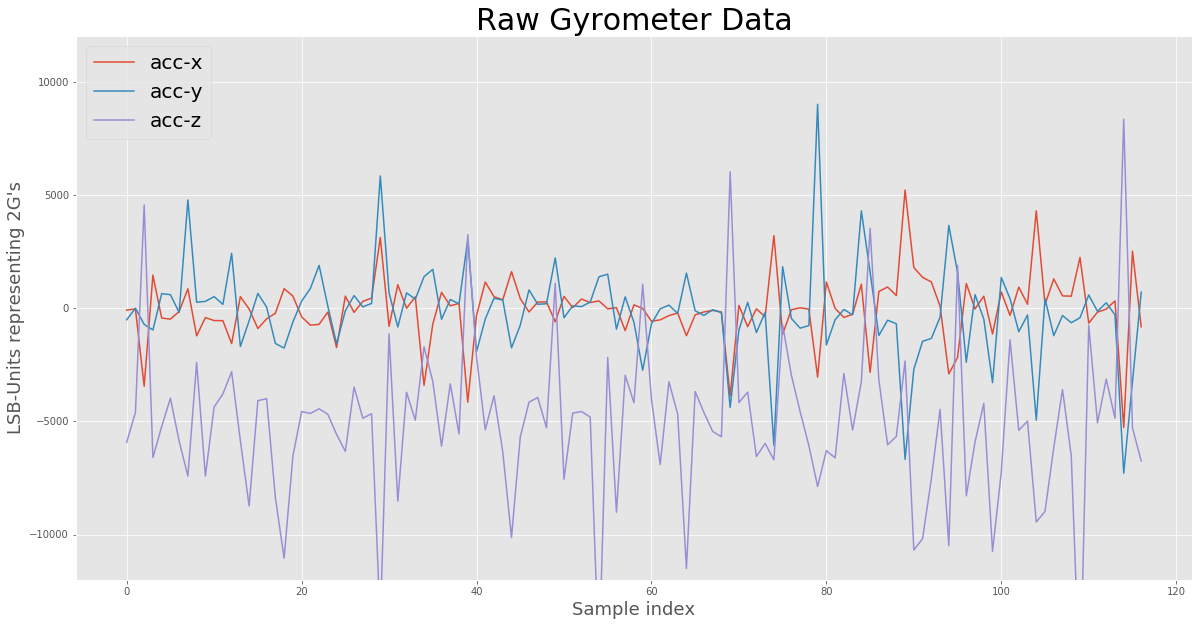

In [57]:
# split flight data into windows of data samples for each label
import csv
import os

def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)

def extract_label_sets_from_file(data_filepath, destination_dir):
    labelled_file = open(data_filepath, 'r')
    
    csv_columns = ['gyro_roll','gyro_pitch','gyro_yaw','acc_x','acc_y','acc_z']
    
    running_index = 0
    running_label = ''
    running_sample_index = {}
    running_sample_filename = ''
    labelled_row_reader = csv.DictReader(labelled_file)
    for labelled_row in labelled_row_reader:
        if(running_label != labelled_row['label']):
            # Iterate sample file index for the current label
            running_label = labelled_row['label']
            if running_label in running_sample_index.keys():
                running_sample_index[running_label] = running_sample_index[running_label] + 1;
            else:
                running_sample_index[running_label] = 0;
            running_index = 0;
            running_sample_filename = destination_dir + '/' + running_label + '/' + running_label + '-sample-' + str(running_sample_index[running_label]) + '.csv'
            ensure_dir(running_sample_filename)
            running_sample_file = open(running_sample_filename, 'w')
            running_sample_file.write(','.join(csv_columns) + '\n')
            running_sample_file.write(labelled_row['gyro_roll']
                                + ',' + labelled_row['gyro_pitch']
                                + ',' + labelled_row['gyro_yaw']
                                + ',' + labelled_row['acc_x']
                                + ',' + labelled_row['acc_y']
                                + ',' + labelled_row['acc_z'] + '\n')
        else:
            running_index = running_index + 1
            running_sample_file.write(labelled_row['gyro_roll']
                                + ',' + labelled_row['gyro_pitch']
                                + ',' + labelled_row['gyro_yaw']
                                + ',' + labelled_row['acc_x']
                                + ',' + labelled_row['acc_y']
                                + ',' + labelled_row['acc_z'] + '\n')

%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from csv import reader

pylab.rcParams['figure.figsize'] = (20, 10)
matplotlib.rcParams['toolbar'] = 'toolbar2'

def graph_raw_flight_record_data(data_filepath):
    with open(data_filepath) as raw_flight_record:
        raw_imu_data = list(reader(raw_flight_record))
    plt.style.use('ggplot')
    gyro_roll = [int(i[1]) for i in raw_imu_data[1::]]
    gyro_pitch = [int(i[2]) for i in raw_imu_data[1::]]
    gyro_yaw = [int(i[3]) for i in raw_imu_data[1::]]
    x_t_index = range(1, len(gyro_roll))
    plt.ion()
    plt.plot(gyro_roll)
    plt.plot(gyro_pitch)
    plt.plot(gyro_yaw)
    plt.gca().set_ylim([-12000, 12000])
    plt.legend(['gyro-roll', 'gyro-pitch', 'gyro-yaw'], fontsize=20)
    plt.title('Raw Gyrometer Data', fontsize=30)
    plt.xlabel('Sample index', fontsize=18)
    plt.ylabel('LSB-Units representing Degrees/Second', fontsize=18)
    plt.show()
    
    acc_x = [int(i[4]) for i in raw_imu_data[1::]]
    acc_y = [int(i[5]) for i in raw_imu_data[1::]]
    acc_z = [int(i[6]) for i in raw_imu_data[1::]]
    plt.plot(acc_x)
    plt.plot(acc_y)
    plt.plot(acc_z)
    plt.gca().set_ylim([-12000, 12000])
    plt.legend(['acc-x', 'acc-y', 'acc-z'], fontsize=20)
    plt.title('Raw Gyrometer Data', fontsize=30)
    plt.xlabel('Sample index', fontsize=18)
    plt.ylabel('LSB-Units representing 2G\'s', fontsize=18)
    plt.show()
    
graph_raw_flight_record_data('./data/training/raw/rotor-dummy-flight-record.csv')

The graph below shows your flight control data that we pulled from S3:

In [ ]:
s3 = boto3.resource('s3')
for bucket in s3.buckets.all():
    print(bucket.name)

## Convert data into a feature space
Extract a features of a sliding window from a given sample data.

In [4]:
#TODO: Change rotor label to the appropriate flight controls
import csv
from itertools import islice
import numpy as np

FEATURE_DATA_FILEPATH = './data/'

feature_csv_columns = ['average', 'median']
imu_data_columns = ['gyro_roll', 'gyro_pitch', 'gyro_yaw', 'acc_x', 'acc_y', 'acc_z']

def feature_average(data_sample):
    fSum = 0;
    nIndex = 0;
    for data in data_sample:
        fSum = fSum + data
        nIndex = nIndex + 1
    return float(fSum / nIndex)

def feature_variance(data_sample):
    return np.var(data_sample)

def feature_median(data_sample):
    return np.median(data_sample, axis=0)

feature_calculations = {
    'average' : feature_average,
    'median' : feature_median
}

# Read a *.csv file and extract the sliding window
import collections
def extract_features_from_imu_data_samples_for_label(data_sample_filepath, features_filepath, data_label):
#     print('Extracting for feature: ', data_label, 'from', data_sample_filepath)
    with open(data_sample_filepath, 'r') as csv_file:
        # extract data records by row
        reader = csv.DictReader(csv_file)
        sliding_windows = []
        sliding_index = 0
        window_step_forward = 1
        window_length = 4
#         if(len(list(reader)) < window_length):
#             print('File too short [' + data_sample_filepath + ']')
#             return
        
        # extract sliding windows from rows
        sliding_window_csv = []
        for row in reader:
            sliding_window_csv.append(row)
            if(len(sliding_window_csv) == window_length + 1):
                del sliding_window_csv[0]
            if(sliding_index % window_step_forward == 0 and len(sliding_window_csv) == window_length):
                sliding_windows.append(list(sliding_window_csv))
            sliding_index = sliding_index + 1
        running_window_lines = []
                
        for feature_name, feature_func in feature_calculations.items():
            for imu_data_column in imu_data_columns:
                window_sequences = []
                for sliding_window in sliding_windows:
                    window_sequence = []
                    for window in sliding_window:
                        window_sequence.append(int(window[imu_data_column]))
                    window_sequences.append(window_sequence)
#                 print(imu_data_column, ' - ', window_sequences)
                
                window_index = 0
                comma_index = 0;
                window_count = len(window_sequences)
                while len(running_window_lines) < window_count:
                    running_window_lines.append('')
                for window in window_sequences:
                    running_window_lines[window_index % window_count] += (str(feature_func(window))) + ','
#                     print(imu_data_column, ' _ ', feature_name, feature_func(window))
                    window_index = window_index + 1
#     print('PRINT FOR WINDOW ', window_count , running_window_lines)

    with open(features_filepath, 'a') as features_file:
        for feature_line in running_window_lines:
            features_file.write(data_label + ',' + feature_line[:-1] + '\n')
            

# Iterate through the raw IMU data directories and get their labels
import glob
import os
labels = set()
print('Extracting labels for samples in raw training data directory:')
for raw_data_dir in glob.glob('./data/training/raw/samples/*', recursive=True):
    labels.add(os.path.basename(raw_data_dir))
print(labels)

labels = set()
print('Extracting labels for samples in raw evaluation data directory:')
for raw_data_dir in glob.glob('./data/evaluation/raw/samples/*', recursive=True):
    labels.add(os.path.basename(raw_data_dir))
print(labels)

#os.remove('./data/features.csv')
with open('./data/training-feature-data.csv', 'w') as file:
    file.write('')

with open('./data/evaluation-feature-data.csv', 'w') as file:
    file.write('')

# Don't include first csv row for training files
#     running_line = 'label,'
#     for feature_columns in feature_csv_columns:
#         for imu_data_column in imu_data_columns:
#             running_line += feature_columns + '_' + imu_data_column + ','
#     running_line = running_line[:-1]
#     running_line += '\n'
#     


# Iterate through each raw IMU data sample and extract their features:
for labelled_features in labels:
    for raw_data_dir in glob.glob('./data/training/raw/samples/' + labelled_features + '/*.csv', recursive=False):
#         print("Extracting features from " + raw_data_dir)
        extract_features_from_imu_data_samples_for_label(raw_data_dir, './data/training-feature-data.csv', labelled_features)

for labelled_features in labels:
    for raw_data_dir in glob.glob('./data/evaluation/raw/samples/' + labelled_features + '/*.csv', recursive=False):
#         print("Extracting features from " + raw_data_dir)
        extract_features_from_imu_data_samples_for_label(raw_data_dir, './data/evaluation-feature-data.csv', labelled_features)

Extracting labels for samples in raw training data directory:
{'rotor4', 'rotor3', 'rotor1', 'rotor2'}
Extracting labels for samples in raw evaluation data directory:
{'rotor4', 'rotor3', 'rotor1', 'rotor2'}



## Implement a linear classifier

In [6]:
import tensorflow as tf
import os
import shutil
import sys

model_dir='./tmp/model'
train_data='./data/training-feature-data.csv'
eval_data='./data/evaluation-feature-data.csv'

# delete the model directory
shutil.rmtree(model_dir, ignore_errors=True)

# declare feature columns within csv
median_gyro_roll = tf.feature_column.numeric_column(key='median_gyro_roll', dtype=tf.float64);
median_gyro_pitch = tf.feature_column.numeric_column(key='median_gyro_pitch', dtype=tf.float64);
median_gyro_yaw = tf.feature_column.numeric_column(key='median_gyro_yaw', dtype=tf.float64);

median_acc_x = tf.feature_column.numeric_column(key='median_acc_x', dtype=tf.float64);
median_acc_y = tf.feature_column.numeric_column(key='median_acc_y', dtype=tf.float64);
median_acc_z = tf.feature_column.numeric_column(key='median_acc_z', dtype=tf.float64);

mean_gyro_roll = tf.feature_column.numeric_column(key='mean_gyro_roll', dtype=tf.float64);
mean_gyro_pitch = tf.feature_column.numeric_column(key='mean_gyro_pitch', dtype=tf.float64);
mean_gyro_yaw = tf.feature_column.numeric_column(key='mean_gyro_yaw', dtype=tf.float64);

# stack feature columns into a single array
imu_window_feature_columns = [median_gyro_roll, median_gyro_pitch, median_gyro_yaw,
        median_acc_x, median_acc_y, median_acc_z,
        mean_gyro_roll, mean_gyro_pitch, mean_gyro_yaw]

run_config=tf.estimator.RunConfig().replace(
    session_config=tf.ConfigProto(device_count={'GPU': 0})
)

def input_fn(data_file):
    assert tf.gfile.Exists(data_file),('%s not found')
    records_default = [['0'],
                       [0.0], [0.0], [0.0],
                       [0.0], [0.0], [0.0],
                       [0.0], [0.0], [0.0],
                       [0.0], [0.0], [0.0]]
    csv_columns = [
                    'rotor',
                    'mean_gyro_roll','mean_gyro_pitch','mean_gyro_yaw',
                    'mean_acc_x','mean_acc_y','mean_acc_z',
                    'median_gyro_roll','median_gyro_pitch','median_gyro_yaw',
                    'median_acc_x','median_acc_y','median_acc_z'
    ]
    
    def parse_csv(value):
        print('PARSING:', data_file)
        columns = tf.decode_csv(value, records_default)
        features = dict(zip(csv_columns, columns))
        labels = features.pop('rotor')
        print('LABELS:', labels)
        return features, labels
    
    dataset = tf.data.TextLineDataset(data_file)
    dataset = dataset.shuffle(200)
    dataset = dataset.map(parse_csv, 4)
    dataset = dataset.batch(200)
    return dataset

model = tf.estimator.LinearClassifier(
    model_dir=model_dir,
    feature_columns=imu_window_feature_columns,
    config=run_config,
    n_classes=4,
    label_vocabulary=['rotor1', 'rotor2', 'rotor3', 'rotor4']
)
# model = tf.estimator.DNNClassifier(
#     model_dir=model_dir,
#     feature_columns=imu_window_feature_columns,
#     config=run_config,
#     hidden_units=[100, 75, 50, 25],
#     n_classes=4,
#     label_vocabulary=['1', '2', '3', '4']
# )



#  <=== Train and evaluate the model every `FLAGS.epochs_per_eval` epochs.  ===>
for n in range(40 // 2):
    model.train(input_fn=lambda: input_fn(
        train_data))

    results = model.evaluate(input_fn=lambda: input_fn(
        eval_data))

    # Display evaluation metricshttps://docs.aws.amazon.com/sagemaker/latest/dg/tf-training-inference-code-template.html
    print('Results at epoch', (n + 1) * 2)
    print('-' * 60)

# model.train(input_fn=lambda: input_fn(
#     train_data))

# results = model.evaluate(input_fn=lambda:input_fn(
#     train_data
# ))

print('[DONE]')

INFO:tensorflow:Using config: {'_tf_random_seed': None, '_save_summary_steps': 100, '_is_chief': True, '_model_dir': './tmp/model', '_keep_checkpoint_max': 5, '_master': '', '_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_save_checkpoints_steps': None, '_num_worker_replicas': 1, '_log_step_count_steps': 100, '_service': None, '_task_id': 0, '_session_config': device_count {
  key: "GPU"
}
, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000024F447F3908>, '_keep_checkpoint_every_n_hours': 10000, '_task_type': 'worker'}
PARSING: ./data/training-feature-data.csv
LABELS: Tensor("DecodeCSV:0", shape=(), dtype=string)
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into ./tmp/model\model.ckpt.
INFO:tensorflow:loss = 44.36142, step = 1
INFO:tensorflow:Loss for final step: 44.36142.
PARSING: ./data/evaluation-feature-data.csv
LABELS: Tensor("DecodeCSV:0", shape=(), dtype=string)
INFO:tensorflow:Starting evaluation a

INFO:tensorflow:Saving checkpoints for 10 into ./tmp/model\model.ckpt.
INFO:tensorflow:loss = 0.0, step = 10
INFO:tensorflow:Loss for final step: 0.0.
PARSING: ./data/evaluation-feature-data.csv
LABELS: Tensor("DecodeCSV:0", shape=(), dtype=string)
INFO:tensorflow:Starting evaluation at 2018-02-26-11:07:36
INFO:tensorflow:Restoring parameters from ./tmp/model\model.ckpt-10
INFO:tensorflow:Finished evaluation at 2018-02-26-11:07:37
INFO:tensorflow:Saving dict for global step 10: accuracy = 1.0, average_loss = 0.0, global_step = 10, loss = 0.0
Results at epoch 20
------------------------------------------------------------
PARSING: ./data/training-feature-data.csv
LABELS: Tensor("DecodeCSV:0", shape=(), dtype=string)
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from ./tmp/model\model.ckpt-10
INFO:tensorflow:Saving checkpoints for 11 into ./tmp/model\model.ckpt.
INFO:tensorflow:loss = 0.0, step = 11
INFO:tensorflow:Loss for final step: 0.0.
PARSING: ./d

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from ./tmp/model\model.ckpt-19
INFO:tensorflow:Saving checkpoints for 20 into ./tmp/model\model.ckpt.
INFO:tensorflow:loss = 0.0, step = 20
INFO:tensorflow:Loss for final step: 0.0.
PARSING: ./data/evaluation-feature-data.csv
LABELS: Tensor("DecodeCSV:0", shape=(), dtype=string)
INFO:tensorflow:Starting evaluation at 2018-02-26-11:08:42
INFO:tensorflow:Restoring parameters from ./tmp/model\model.ckpt-20
INFO:tensorflow:Finished evaluation at 2018-02-26-11:08:42
INFO:tensorflow:Saving dict for global step 20: accuracy = 1.0, average_loss = 0.0, global_step = 20, loss = 0.0
Results at epoch 40
------------------------------------------------------------
[DONE]
